# Inicializando acesso ao Google Drive

In [1]:
'''
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get -qq install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get -qq update -qq 2>&1 > /dev/null
!apt-get -y -qq install -qq google-drive-ocamlfuse fuse
print('Installed')
'''

"\n# Install a Drive FUSE wrapper.\n# https://github.com/astrada/google-drive-ocamlfuse\n!apt-get -qq install -y -qq software-properties-common python-software-properties module-init-tools\n!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null\n!apt-get -qq update -qq 2>&1 > /dev/null\n!apt-get -y -qq install -qq google-drive-ocamlfuse fuse\nprint('Installed')\n"

In [2]:
'''
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

#print 'Files in Drive:'
!ls drive/"Colab Notebooks"/i2dl/tp1/dl/datasets/"cifar-10-batches-py"/
'''

'\n# Generate auth tokens for Colab\nfrom google.colab import auth\nauth.authenticate_user()\n\n# Generate creds for the Drive FUSE library.\nfrom oauth2client.client import GoogleCredentials\ncreds = GoogleCredentials.get_application_default()\nimport getpass\n!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL\nvcode = getpass.getpass()\n!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}\n\n# Create a directory and mount Google Drive using that directory.\n!mkdir -p drive\n!google-drive-ocamlfuse drive\n\n#print \'Files in Drive:\'\n!ls drive/"Colab Notebooks"/i2dl/tp1/dl/datasets/"cifar-10-batches-py"/\n'

# Atividade 04: Implementando uma Rede Neural

*Complete e entregue toda essa atividade (incluindo suas saídas e qualquer código adicional que você desenvolva) juntamente com a submissão de seu trabalho prático. Maiores detalhes podem ser vistos na página da disciplina.*

Nesta atividade, você irá desenvolver uma rede neural com camadas completamente conectadas para realizar classificação de imagens, e irá testá-la utilizando o dataset CIFAR-10.

Nesta atividade, você irá:

- implementar uma **função de perda** (**loss function**) para uma rede neural de duas camadas
- implementar a expressão para seu **gradiente analítico**
- **verificar sua implementação** utilizando gradiente numérico
- **treinar** sua em um pequeno problema por meio de **SGD**
- **treinar e depurar** sua rede em um conjunto de **dados reais**
- usar um conjunto de validação para **ajustar hiperparâmetros**
- **visualizar** os pesos finais que foram obtidos


In [3]:
# Algum código de inicialização

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returna erro relativo """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [4]:
#PATH_DIRECTORY = 'drive/Colab Notebooks/i2dl/tp1'
#os.chdir(PATH_DIRECTORY)
from dl.classifiers.neural_net import TwoLayerNet
from __future__ import print_function

Nesta atividade será utilizada a classe `TwoLayerNet` que está definida dentro do arquivo `dl/classifiers/neural_net.py` para representar instâncias de uma rede neural.

Os parâmetros da rede serão armazenados na variável de instância `self.params` que é um dicionário em que as chaves são os nomes (*strings*) de cada parâmetro e os valores são **arrays numpy**.

A seguir, você irá inicializar um pequeno conjunto de dados e um modelo simples que será usado para iniciar o desenvolvimento de sua implementação. 

In [5]:
# Cria um pequeno conjunto de dados aleatórios e um modelo simples para verificar sua implementação.
# Veja que foi fixado a 'semente aleatória' para possibilitar a repetição de experimentos

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Passo de Propagação (*Forward pass*): cálculo de *scores*
Abra o arquivo `dl/classifiers/neural_net.py` e analise o método `TwoLayerNet.loss`. 

Esta função é muito similar as funções de perda que você escreveu anteriormente para as atividades envolvendo os modelos SVM e Softmax: ela utiliza os dados e os pesos (ou parâmetros) para calcular os *scores* de cada classe, o valor de perda/custo e os gradientes em relação aos parâmetros.

Você deve implementar a primeira parte do passo de propagação (*forward pass*) que utiliza os pesos e vieses (*biases*) para calcular os escores para todas as entradas.

In [6]:
from dl.classifiers.neural_net import TwoLayerNet
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# A diferença deve ser bem pequena, algo < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.680272093239262e-08


# Passo de Propagação (*Forward pass*): cálculo da perda/custo
Na mesma função, você deve implementar a segunda parte do passo de propagação (*forward pass*) responsável pelo cálculo da perda envolvendo os dados e a regularização.

In [7]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# Novamente, a diferença deve ser pequena, algo < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


# Passo de Retropropagação (*Backward pass*)
Você deve implementar os restante da função `TwoLayerNet.loss`, de modo que a função calcule o gradiente da perda em relação aos parâmetros `W1`, `b1`, `W2` e `b2`.

Agora, uma vez que você implementou corretamente o passo de propagação, você pode depurar o passo de retropropagação como feito anteriormente: por meio do uso de estimativas numéricas do gradiente.

In [8]:
from dl.gradient_check import eval_numerical_gradient

# Usa verificação numérica do gradiente para checar sua implementação do passo de retropropagação.
# Se sua implementação estiver correta, a diferença entre a estimativa numérica do gradiente
# e o valor obtido analiticamente deve ser menor que 1e-8 para cada um dor parâmetros.

loss, grads = net.loss(X, y, reg=0.05)

# O erros deve ser menores que 1e-8
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.561318e-09
b1 max relative error: 6.666667e-01
W2 max relative error: 3.440708e-09
b2 max relative error: 6.666667e-01


# Treinamento de uma Rede Simples
Para treinar uma rede, você deve usar o método SGD (método de descida mais íngreme estocástico), similar ao realizado com os classificarores SVM e Softmax.

Analise a função `TwoLayerNet.train` e preencha as partes que faltam para implementar o procedimento de treinamento. Isso deve ser muito similar ao realizado para os classificadores SVM e Softmax. 

Você também deve implementar a função `TwoLayerNet.predict` pois ela será necessária durante o treinamento, uma vez que periodicamente o método realiza predições para acompanhar a acurácia ao longo do processo.

Uma vez que você tenha implementados tais métodos, execute o código abaixo para treinar um rede de duas camadas sobre o pequeno conjunto de dados aletários. Você deverá obter uma perda ao final do treinamento inferior a 0.2

Final training loss:  0.0023257338261280704


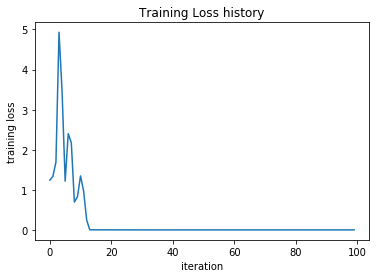

In [9]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# Plota o histórico da função de perda
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Carregamento de dados
Agora que você implementou uma rede de duas camadas que passou pela verificação de gradientes e funcionado sobre o pequeno conjunto de dados, é hora de carregar os dados do CIFAR-10 dataset de modo que você possa usá-los no treinamento de um classificador sobre dados reais.

In [10]:
from dl.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Carrega CIFAR-10 dataset a partit do disco e realiza preprocessamento para preparar
    os dados para a rede neural de duas camadas. Estes são os mesmos passos usados para o modelo
    SVM, porém condensado em uma única função.  
    """
    # Carregga os dados CIFAR-10 brutos
    cifar10_dir = 'dl/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subdivide os dados em conjuntos
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normaliza os dados: subtrai a imagem média
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Redimensiona as imagens de matrizes para vetores
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Usar a função definida acmina para obter os dados.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Treinamento de uma Rede com Dados Reais
Para treinar sua rede, você deve usar **SGD+momentum**. Além disso, nesse processo a taxa de aprendizado será ajustada com um decaimento exponencial ao longo do processo de otimização, isto é, após cada época, a taxa de aprendizado é multiplicada pela taxa de decaimento (como esta última é menor que um, consequentemente a taxa de aprendizado é reduzida).

In [11]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Treinamento da rede
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1500, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predição sobre o conjunto de validação
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1500: loss 2.302762
iteration 100 / 1500: loss 2.302317
iteration 200 / 1500: loss 2.297339
iteration 300 / 1500: loss 2.258875
iteration 400 / 1500: loss 2.200012
iteration 500 / 1500: loss 2.110139
iteration 600 / 1500: loss 2.044487
iteration 700 / 1500: loss 1.983243
iteration 800 / 1500: loss 2.000518
iteration 900 / 1500: loss 1.943900
iteration 1000 / 1500: loss 1.939201
iteration 1100 / 1500: loss 1.933310
iteration 1200 / 1500: loss 1.942107
iteration 1300 / 1500: loss 1.956793
iteration 1400 / 1500: loss 1.877446
Validation accuracy:  0.325


# Depuração do treinamento
Com os valores de parâmetros fornecidos acima, você deve ter obtido uma acurácia no conjunto de validação em torno de 0.29. O que não representa um resultado muito bom...

Uma estratpegia para melhorar o entendimento (fornecer *insigths*) sobre o que pode estar errado é traçar os gráficos de evolução da função de perda e das acurácias de treinamento e validação ao longo do processo de otimização.

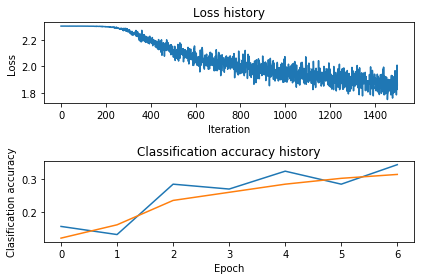

In [12]:
# Plota a funcão de pedar e as acurácias de treinamento e validação
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.tight_layout()
plt.show()

Uma outra estratégia é construis uma visualização dos pesos que foram obtidos na primeira camada da rede. Por trás disto, está o fato de que na maioria das redes neurais treinadas sobre dados visuais, os pesos da primeira camada geralmente exibem algum tipo de estrutura visível.

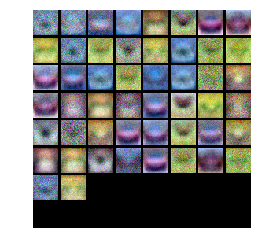

In [13]:
from dl.vis_utils import visualize_grid

# Visualiza os pesos da primeira camada da rede

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Ajuste de hiperparâmetros

**O que está errado?** Observando os gráficos e as visualizações acima, pode-se ver que a perda está reduzindo de forma *mais ou menos* linear, o que parece sugerir que a taxa de aprendizado pode estar muito baixa. Além disso, não há uma separação grande entre as acurácias de treinamento e validação, sugerindo que o modelo usado tem baixa capacidade e que talvez seu tamanho devesse ser aumentado. Por outro lado, com um modelo muito grande deve-se esperar observar mais *overfitting*, que se manifesta por meio de uma distância muita grande entre acurácias de treinamento e de validação.

**Ajuste**. Realizar o ajuste de hiperparâmetros e desenvolver uma nocão intuitiva de como eles afetam o resultado final é uma parte importatnte do uso de Redes Neurais. Dessa forma, deseja-se que você realize várias práticas envolvendo o ajuste de hiperparâmetros. A seguir, você deve realizar experimentos com diferentes valores para os hiperparâmetros incluindo: tamanho da camada escondida, taxa de aprendizado, taxa de decaimento, número de épocas de treinamento e regularização. 

**Resultados aproximados**. Você deve tentar alcançar uma acurácia de classificação (taxa de acerto) maior que 48% no conjunto de validação. (OBS: minha solução obteve uma acurácia acima de 52% no conjunto de validação!)

**Experimento**: O objetivo desse exercício é que você tente obter o melhor resultado sobre a base CIFAR-10, usando uma rede neural completamente conectada. Para cada 1% acima de 52% sobre a acurácia no **conjunto de teste**, você irá receber um ponto extra. Sinta-se livre para implementar quaisquer técnicas que desejar (p.ex., redução de dimensionalidade via PCA, *dropout*, ou outras estratégias ao otimizador, etc).

**OBS: Lembre-se de deixar documentado tudo que foi feito! Caso necessário, acrescente mais células a sua vontade.**

In [21]:
best_net = None # Armazenar o melhor modelo encontrado nesse variável pois será 
                # usado no teste final (ver final desse notebook)

#################################################################################
# TODO: Ajustar hiperparâmetros usando o conjunto de validação. O melhor modelo #
# obtido ao longo do treinamento deve-se armazenado em best_net.                #
#                                                                               #
# Para auxiliar a depurar sua rede, pode ser interessante se utilizar de        #
# visualizações similares as usadas acima. Essas visualizações irão apresentar  #
# diferenças qualitativas significativas especialmente para redes com ajustes   #
# ruins.                                                                        #
#                                                                               #
# O ajuste fino de hiperparâmetros feito manualmente pode ser divertido, mas    #
# provavelmente você deverá considerar a possibilidade de escrever código que   #
# percorra todas as combinações possíveis de hiperparâmetros de forma a tornar  #
# automático o processo de busca (similar ao que foi feito nas atividades       #
# anteriores).                                                                  #
#################################################################################

results = {}
best_val = -1
learning_rates = [1e-3] #[5e-3] #[1e-3, 5e-4, 1e-4] #[5e-2, 1e-2, 5e-3]
regularization_strengths = [0.1] #0.01, 0.1] #, 0.25] #, 0.4, 0.5]
batch_sizes = [100] #[10, 50, 100, 200]
decay =  [0.95] #[0.9, 0.95]

#num iterações
n_iters = 3000

#net
input_size = 32 * 32 * 3
hidden_size = 256 #512 #1024
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

#valores
best_train = 0
best_lr = 0
best_reg = 0
best_batch = 0

for lr in learning_rates:
    for reg in regularization_strengths:
        for batch in batch_sizes:
            for dec in decay:
                stats = net.train(X_train, y_train, X_val, y_val, num_iters=n_iters, 
                            batch_size=batch, learning_rate=lr, learning_rate_decay=dec,
                            reg=reg, verbose=False)

                #print
                cur_train = stats['train_acc_history'][-1]
                cur_valid = stats['val_acc_history'][-1]

                print('train: %.4f val: %.4f' % (cur_train, cur_valid))
                print('lr: %e reg: %e batch: %.2f iter: %.1f dec: %.2f' % (lr, reg, batch, n_iters, dec))

                if cur_valid > best_val:
                    best_val = cur_valid
                    best_train = cur_train
                    best_lr = lr
                    best_reg = reg
                    best_batch = batch
                    best_net = net
#################################################################################
#                              FIM DE SEU CÓDIGO                               #
#################################################################################

train: 0.7700 val: 0.5180
lr: 1.000000e-03 reg: 1.000000e-01 batch: 100.00 iter: 3000.0 dec: 0.95


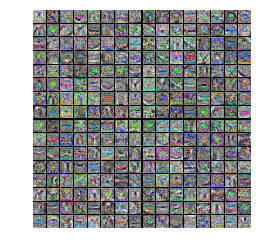

In [22]:
# visualizar os pesos da primeira camada da melhor rede obtida
show_net_weights(best_net)

# Executar predições sobre o conjunto de teste
Quando você terminar com seus experimentos acima (**nunca antes!!!**), você deve avaliar sua rede final sobre o conjunto de teste e o resultado de acurácia (taxa de acerto) deve ser acima de 48%.

**Você irá ganhar ponto extra para cada 1% de acurácia obtido acima de 52%.**

In [23]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.528
